In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/audio_dataset/spectrogram_labels.csv")

# Filter all 8 emotions (assuming valid rows only)
df = df[df['emotion'].notna()]
target_emotions = sorted(df['emotion'].unique())

# Load and preprocess images
img_size = (128, 128)
X = []
y = []

for i, row in df.iterrows():
    try:
        img = cv2.imread(row['filepath'])
        img = cv2.resize(img, img_size)
        X.append(img)
        y.append(row['emotion'])
    except:
        print(f"Error loading image: {row['filepath']}")

X = np.array(X) / 255.0  # Normalize
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_encoded = tf.keras.utils.to_categorical(y_encoded)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

In [ ]:
output_dir =  "/content/drive/MyDrive/audio_dataset/saved_test_spectrograms"
os.makedirs(output_dir, exist_ok=True)

# Save each image from X_test as PNG with the corresponding label
for i, (img, label_vec) in enumerate(zip(X_test, y_test)):
    label_index = np.argmax(label_vec)  # Convert one-hot to label index
    filename = f"test_img_{i}_label_{label_index}.png"
    filepath = os.path.join(output_dir, filename)

    # Rescale image from 0–1 to 0–255 and save
    img_to_save = (img * 255).astype(np.uint8)
    cv2.imwrite(filepath, img_to_save)


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(target_emotions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Early stopping
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.1875 - loss: 2.1149 - val_accuracy: 0.2566 - val_loss: 1.9079
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.2626 - loss: 1.8680 - val_accuracy: 0.3788 - val_loss: 1.6803
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.3681 - loss: 1.6210 - val_accuracy: 0.4134 - val_loss: 1.5787
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4515 - loss: 1.4575 - val_accuracy: 0.4644 - val_loss: 1.4225
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4697 - loss: 1.3782 - val_accuracy: 0.4969 - val_loss: 1.2908
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.5505 - loss: 1.2028 - val_accuracy: 0.5580 - val_loss: 1.1747
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.5890 - loss: 1.0995 - val_accuracy: 0.5540 - val_loss: 1.1272
Epoch 8/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.6175 - loss: 1.0271 - val_accuracy: 0.6191 - val_loss:

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step

=== Confusion Matrix ===
[[66  0  1  3  3  0  1  1]
 [ 0 56  0  1  6  4  8  0]
 [ 4  1 28  2  1  0  2  1]
 [ 5  0  0 61  4  0  5  0]
 [ 3  1  0  3 61  1  5  1]
 [ 0  0  0  1  0 32  5  0]
 [ 0  6  1 10  5  2 51  0]
 [ 0  0  1  3  5  1  0 29]]

=== Classification Report ===
              precision    recall  f1-score   support

       angry       0.85      0.88      0.86        75
        calm       0.88      0.75      0.81        75
     disgust       0.90      0.72      0.80        39
     fearful       0.73      0.81      0.77        75
       happy       0.72      0.81      0.76        75
     neutral       0.80      0.84      0.82        38
         sad       0.66      0.68      0.67        75
   surprised       0.91      0.74      0.82        39

    accuracy                           0.78       491
   macro avg       0.80      0.78      0.79       491
weighted avg       0.79      0.78      0.78       491


=== Accuracy: 78.21%
=== Macro F1

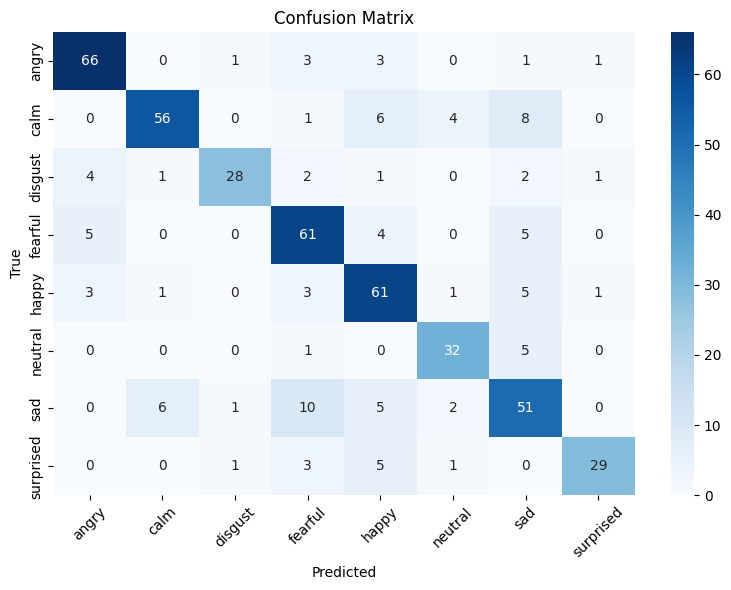

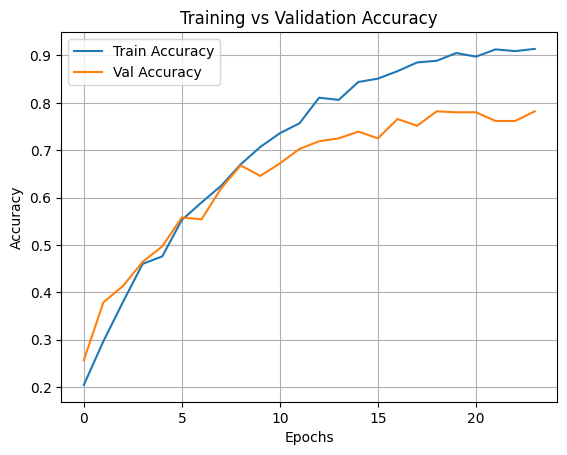

In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
acc = accuracy_score(y_true_labels, y_pred_labels)
f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

print("\n=== Confusion Matrix ===")
print(conf_matrix)

print("\n=== Classification Report ===")
print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))

print(f"\n=== Accuracy: {acc*100:.2f}%")
print(f"=== Macro F1 Score: {f1*100:.2f}%")

# Confusion Matrix Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Training History Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save("emotion_cnn_model.h5")